In [1]:
%load_ext autoreload
%autoreload 2
from MODM_Tool_Modules import gathering_data_function as gt
from MODM_Tool_Modules.PROMETHEE_Modules import PROMETHEE_data_processing as pm_process
from MODM_Tool_Modules.PROMETHEE_Modules import PROMETHEE_plotting_results_function as pm_plot
from MODM_Tool_Modules.PROMETHEE_Modules import PROMETHEE_saving_results as pm_save 
from MODM_Tool_Modules.PROMETHEE_Modules import PROMETHEE_sensitivity_analysis as pm_sens

In [2]:
decision_matrix, data_filename, weights, normalized_weights, beneficial_criteria, non_beneficial_criteria = gt.gathering_data(
    'C:/Users/Virgi/OneDrive/Bureau/MODM_tool_project/Tool/Data/data_input/mock_data.csv')

              Price ($)  Storage (GB)  Camera (MP)  Looks (1-5)
Alternative                                                    
Phone 1             250            16           12            5
Phone 2             200            16            8            3
Phone 3             300            32           16            4
Phone 4             275            32            8            4
Phone 5             225            16           16            2


In [3]:
user_input = input(
    "Do you want to save the results of this run? (yes/no): ").strip().lower()
directory = None
if user_input == 'yes':
    directory = pm_save.directory_creation(data_filename)

In [4]:
preference_functions = pm_process.define_preference_functions(decision_matrix)
net_flows, ranked_alternatives, ranks = pm_process.PROMETHEE_data_processing(decision_matrix, beneficial_criteria, normalized_weights, preference_functions)

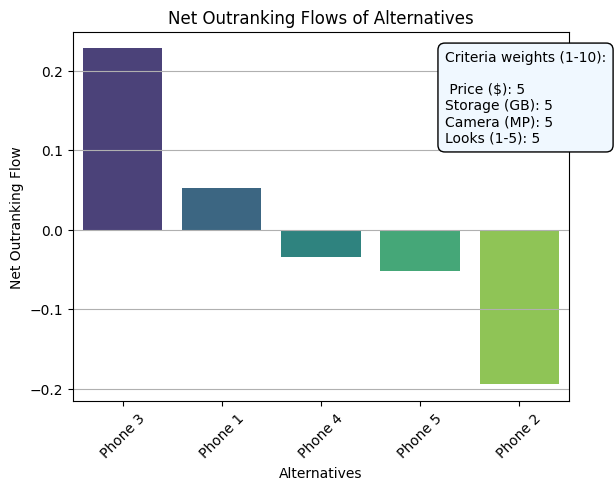

Alternative
Phone 3    0.228154
Phone 1    0.052525
Phone 4   -0.034118
Phone 5   -0.051878
Phone 2   -0.194683
dtype: float64


In [5]:
pm_plot.results_visualization_promethee(net_flows, weights, user_input, directory, ranked_alternatives)

Initial weight for  Price ($): 5
Initial weight for Storage (GB): 5
Initial weight for Camera (MP): 5
Initial weight for Looks (1-5): 5


100%|██████████| 2000/2000 [00:36<00:00, 54.13it/s]


Phone 3
100.0


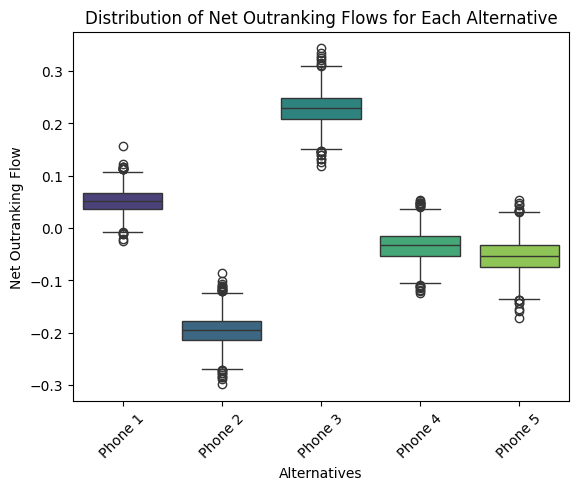

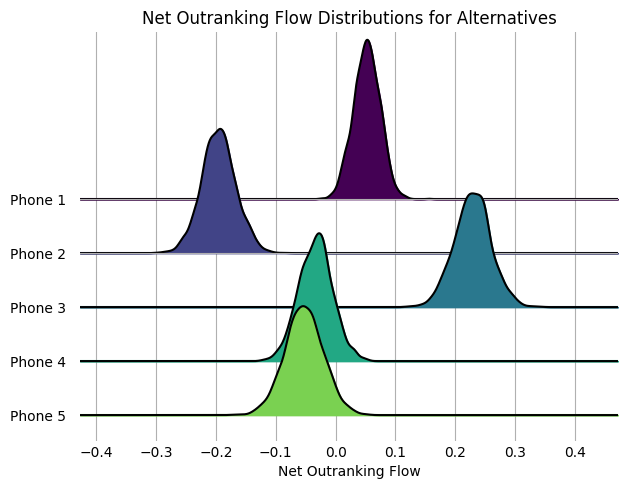

In [6]:
user_input2 = input(
    "Do you want to run a sensitivity analysis? (yes/no): ").strip().lower()
if user_input2 == 'yes':
    uncertainties, net_flows_df, ranks_df, reliability_percentage, initial_best_solution = pm_sens.sensitivity_analysis(pm_process.PROMETHEE_data_processing, weights, 10000, 0, 10, decision_matrix, beneficial_criteria, net_flows, user_input, directory, preference_functions)

In [7]:
if user_input == 'yes':
    pm_save.save_run_results(
        directory,
        decision_matrix,
        preference_functions,
        ranked_alternatives,
        weights,
        beneficial_criteria,
        non_beneficial_criteria,
    )
    
if user_input2 == 'yes' and user_input == 'yes':
    pm_save.save_sensitivity_results(
        directory,
        uncertainties,
        net_flows_df,
        ranks_df,
        reliability_percentage,
        initial_best_solution)